In [1]:
import mediapy as media
import copy
import mujoco
import numpy as np
from robot_descriptions.loaders.mujoco import load_robot_description

from mujoco_sysid.parameters import get_dynamic_parameters
from mujoco_sysid.regressors import joint_torque_regressor
from utils import ActuatorMotor, update_actuator
from mujoco_logger import SimLogger

model = load_robot_description("panda_mj_description", variant="panda_nohand")
# disable collisions
model.opt.disableflags |= (
    mujoco.mjtDisableBit.mjDSBL_CONTACT | mujoco.mjtDisableBit.mjDSBL_FRICTIONLOSS | mujoco.mjtDisableBit.mjDSBL_LIMIT
)

for actuator_id in range(model.nu):
    actuator = ActuatorMotor()
    update_actuator(model, actuator_id, actuator)

data = mujoco.MjData(model)

try:
    renderer
except:
    renderer = mujoco.Renderer(model, height=480, width=640)

In [2]:
# model and data specifically to perform controller computations
cmodel = copy.deepcopy(model)
cdata = copy.deepcopy(data)


def controller(q, v, dv_desired, theta_est):
    """
    Inverse dynamics controller with feedforward term.
    """

    cdata.qpos[:] = q.copy()
    cdata.qvel[:] = v.copy()
    cdata.qacc[:] = dv_desired.copy()
    mujoco.mj_inverse(cmodel, cdata)
    mujoco.mj_rnePostConstraint(cmodel, cdata)

    Y = joint_torque_regressor(cmodel, cdata)
    return Y @ theta_est

In [3]:
# ideal set of dynamic parameters
theta = np.concatenate([get_dynamic_parameters(model, i) for i in model.jnt_bodyid])

# perturbed set of dynamic parameters
theta_perturbed = theta.copy()
theta_perturbed *= np.random.uniform(0.4, 1.5, size=theta.shape)

In [4]:
# generate waypoints in joint space
N_WAYPOINTS = 50
T_WAYPOINT = 1.0  # time spent moving to each waypoint

np.random.seed(0)
waypoints = np.random.uniform(model.jnt_range[:, 0], model.jnt_range[:, 1], size=(N_WAYPOINTS, model.nq))

In [5]:
mujoco.mj_resetData(model, data)

KP = 30
KD = np.sqrt(4 * KP)

framerate = 30
frames = []

qhist = []
qtarget = []

with SimLogger(model, data, output_filepath="invdyn.json") as logger:
    while data.time < T_WAYPOINT * N_WAYPOINTS:
        # compute the current waypoint
        waypoint_idx = int(data.time // T_WAYPOINT)

        # compute the desired configuration
        q_desired = waypoints[waypoint_idx]
        v_desired = np.zeros_like(q_desired)

        # compute the target acceleration
        target_acc = KP * (q_desired - data.qpos) + KD * (v_desired - data.qvel)

        # compute the control signal
        tau = controller(data.qpos, data.qvel, target_acc, theta_perturbed)

        # apply the control signal
        data.ctrl[:] = tau

        # record the log
        qhist.append(data.qpos.copy())
        qtarget.append(q_desired)

        # step the simulation
        mujoco.mj_step(model, data)
        logger.record()

        if len(frames) < data.time * framerate:
            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)


media.show_video(frames, fps=framerate)

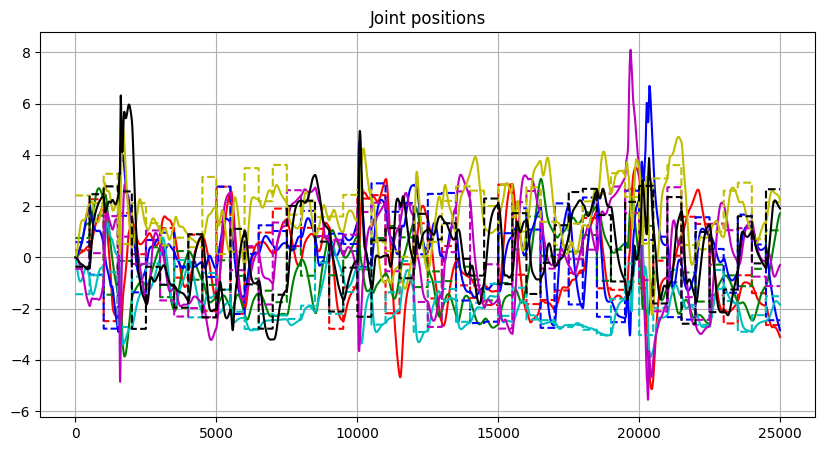

In [6]:
import matplotlib.pyplot as plt

qhist = np.array(qhist)
qtarget = np.array(qtarget)

each_joint_color = ["r", "g", "b", "c", "m", "y", "k"]

plt.figure(figsize=(10, 5))
plt.title("Joint positions")
for jidx in range(7):
    plt.plot(qhist[:, jidx], color=each_joint_color[jidx])
    plt.plot(qtarget[:, jidx], linestyle="--", color=each_joint_color[jidx])

plt.grid()
plt.show()

## Offline estimation of the parameters using joint torque regressor

In [7]:
from mujoco_logger import SimLog

log = SimLog("invdyn.json")


def construct_regression(log: SimLog):
    N = len(log)
    A = np.zeros((N * model.nv, len(theta)))
    b = np.zeros((N * model.nv,))

    for i in range(N):
        q = log[i].data("qpos")
        v = log[i].data("qvel")
        dv = log[i].data("qacc")
        tau = log[i].data("ctrl")

        cdata.qpos[:] = q
        cdata.qvel[:] = v
        cdata.qacc[:] = dv

        mujoco.mj_inverse(cmodel, cdata)
        mujoco.mj_rnePostConstraint(cmodel, cdata)

        Y = joint_torque_regressor(cmodel, cdata)

        A[i * model.nv : (i + 1) * model.nv, :] = Y
        b[i * model.nv : (i + 1) * model.nv] = tau

    return A, b


A, b = construct_regression(log)

theta_est = np.linalg.lstsq(A, b, rcond=None)[0]

print("True parameters:")
print(theta)

print("Estimated parameters:")
print(theta_est)

np.linalg.norm(theta - theta_est)

True parameters:
[ 4.97068400e+00  1.92614005e-02  1.03439934e-02 -2.36703972e-01
  7.14663369e-01 -1.79087434e-04  7.17956456e-01  7.68922777e-03
  1.96620379e-02  9.21318890e-03  6.46926000e-01 -2.03199457e-03
 -1.85797147e-02  2.26100637e-03  8.50351116e-03 -3.98335872e-03
  2.81242848e-02  1.02611015e-02  7.68935939e-04  2.65349923e-02
  3.22860400e+00  8.88447249e-02  1.26729164e-01 -2.14708623e-01
  5.64949260e-02 -8.24833314e-03  5.28783820e-02 -5.48764810e-03
 -4.37725712e-03  1.82492023e-02  3.58789500e+00 -1.90768377e-01
  3.74644408e-01  9.85020693e-02  6.76772726e-02  2.77158413e-02
  3.23994297e-02  3.90535528e-03 -1.64448587e-03  7.75861474e-02
  1.22594600e+00 -1.46537325e-02  5.03434725e-02 -4.71216864e-02
  3.94275710e-02 -1.51524448e-03  3.14603723e-02 -4.60024554e-03
  2.16405199e-03  1.08695108e-02  1.66655500e+00  1.00241617e-01
 -2.35267569e-02 -1.75271589e-02  2.48046033e-03  1.52411091e-03
  1.05677661e-02 -1.03758875e-04  9.35690967e-05  1.17945603e-02
  7.3552

7.3288181818444995

In [10]:
# # from mujoco_sysid.convert import theta2logchol, logchol2theta
from mujoco_sysid.mjx.convert import theta2logchol, logchol2theta

# print("Distance in Log-Cholesky between true and estimated parameters:")
# try:
#     logchol_theta = np.concatenate([theta2logchol(thetai) for thetai in np.split(theta, 7)])
#     logchol_theta_est = np.concatenate([theta2logchol(thetai) for thetai in np.split(theta_est, 7)])

#     print(np.linalg.norm(logchol_theta - logchol_theta_est))
# except np.linalg.LinAlgError as e:
#     print("Estimation is not fully physically consistent.")
#     print(e)

In [11]:
logcholideal = np.concatenate([theta2logchol(thetai) for thetai in np.split(theta, 7)])

In [12]:
import optax

In [29]:
import functools

import jax
import jax.numpy as jnp


@functools.partial(jax.vmap, in_axes=(None, 0))
def network(params, x):
    return jnp.dot(params, x)


@jax.jit
def compute_loss(parameters, A, b):
    # convert x from logcholesky to theta
    theta = jnp.concatenate([logchol2theta(xi) for xi in jnp.split(parameters, 7)])

    y_pred = network(A, theta)
    print(A.shape, theta.shape, b.shape)
    loss = jnp.sum(optax.l2_loss(y_pred, b))
    return loss

In [30]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = logcholideal
opt_state = optimizer.init(params)

In [31]:
# A simple update loop.
for i in range(1000):
    grads = jax.grad(compute_loss)(params, A, b)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # # params to theta list
    # theta_identified = np.concatenate([logchol2theta(parami) for parami in np.hsplit(params, 7)])

    # euclidean_loss = np.linalg.norm(theta_identified - theta)
    logcholesky_loss = np.linalg.norm(params - logcholideal)

    # Euclidean Loss: {euclidean_loss:.4f}
    print(f"Iteration {i}. LogCholesky Loss: {logcholesky_loss:.4f}")

# assert jnp.allclose(params, target_params), "Optimization sh0ould retrive the target params used to generate the data."
params

(70,) (70,) (175000,)


AssertionError: [Chex] Assertion assert_equal_shape failed: Arrays have different shapes: [(70, 70), (175000,)].

In [ ]:
# np.linalg.norm(params - logcholideal)
# params to theta list
theta_identified = np.concatenate([logchol2theta(parami) for parami in np.hsplit(params, 7)])

np.linalg.norm(theta_identified - theta)

6.460824369349273